In [ ]:
!pip install google-play-scraper
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np # numerical operation
import pandas as pd # data analysis and processing
import seaborn as sns # visualization
from pylab import rcParams # colab parameters

import matplotlib.pyplot as plt # visualization utility
from matplotlib import rc

from sklearn.model_selection import train_test_split # training  ML model
from sklearn.metrics import confusion_matrix, classification_report # analyzing model performance
from sklearn.utils import compute_class_weight

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup # bert access
import torch # pytorch
from torch import nn, optim, Tensor # modules for training
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict # utilities
from textwrap import wrap
import requests
import warnings
warnings.filterwarnings('ignore')

from google_play_scraper import reviews, reviews_all, Sort # getting reviews

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2) # seaborn config
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 69 # random numbers config
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Wolt

## Gather Data

In [ ]:
wolt_id_android = 'com.wolt.android'

In [ ]:
wolt_reviews, _ = reviews(
    wolt_id_android,
    lang="ru",
    country="kz",
    count=15000
)


wolt_reviews = pd.DataFrame(wolt_reviews)
wolt_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,98f358bc-98d8-4b85-8507-e0c90564f834,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,запрашивает эмейл. не приходит код. тех поддер...,1,0,None,2025-03-17 15:49:13,None,None,None
1,dab3cf83-d070-4489-952e-d39121fd1920,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Не понятна сумма минимального заказа, не удало...",1,0,None,2025-03-17 14:26:55,None,None,None
2,8a9e09d5-0ec8-4af5-a8d2-90bae6086578,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,good service!,5,0,25.10.1,2025-03-16 19:59:16,None,None,25.10.1
3,ad39cccc-2d11-4c9a-996f-6c41508b5d91,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Регу по проще сделайте. Не смог войти удалил с...,1,0,None,2025-03-16 17:47:33,None,None,None
4,2c6ab6f0-620c-4f39-92c2-b92f9ad1b64c,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Отличная доставка,быстро,все отслеживается",5,0,25.10.1,2025-03-16 14:37:55,None,None,25.10.1


In [ ]:
wolt_reviews = wolt_reviews[wolt_reviews['content'].str.len() > 20]
print(wolt_reviews.shape)
wolt_reviews.head()

(8045, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,98f358bc-98d8-4b85-8507-e0c90564f834,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,запрашивает эмейл. не приходит код. тех поддер...,1,0,None,2025-03-17 15:49:13,None,None,None
1,dab3cf83-d070-4489-952e-d39121fd1920,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Не понятна сумма минимального заказа, не удало...",1,0,None,2025-03-17 14:26:55,None,None,None
3,ad39cccc-2d11-4c9a-996f-6c41508b5d91,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Регу по проще сделайте. Не смог войти удалил с...,1,0,None,2025-03-16 17:47:33,None,None,None
4,2c6ab6f0-620c-4f39-92c2-b92f9ad1b64c,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Отличная доставка,быстро,все отслеживается",5,0,25.10.1,2025-03-16 14:37:55,None,None,25.10.1
8,cc62ebd2-2c38-4437-b1ab-31ecfab54d29,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Рекомендую!!! Акции скидки и дешевлее чем Узум...,5,0,25.10.1,2025-03-16 13:18:32,None,None,25.10.1


In [ ]:
def to_sentiment(rating):
    rating = int(rating)

    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

wolt_reviews['sentiment'] = wolt_reviews.score.apply(to_sentiment)
wolt_reviews[['content', 'sentiment']].sample(10)

,content,sentiment
1063,"Бесплатный доставка сейчас, прям по душе",2
9440,Всë отлично работает. Первый раз заказал и всë...,2
12187,"Хорошего дня вам, всё понравился!!! Главное бе...",2
12109,Yeridim dostavkaviza blyat,0
954,Zo'r tezkor yetkazib berdi,2
9994,Бишманская программа ! Отсутствует кнопка ВОЙТИ,0
8818,"Отличное приложение,мое любимое!! Аккуратные к...",2
404,Долгая доставка и еда приезжает холодной у дос...,0
3134,Nie działa w Świętokrzyskiem,0
5238,Не скачате сечас на wolt не заходит Луче скача...,0


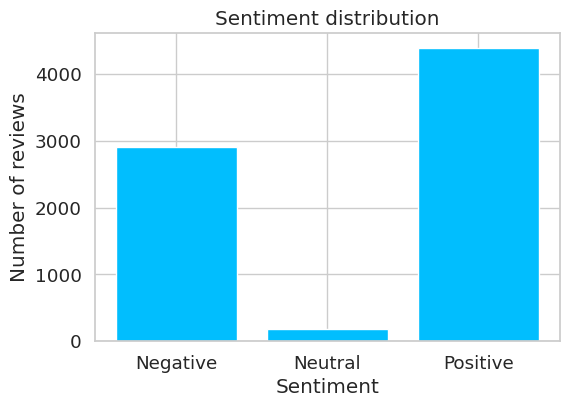

In [ ]:
# Plot the distribution
plt.figure(figsize=(6,4))
plt.bar([0,1,2], np.array(wolt_reviews.sentiment.value_counts().sort_index()))
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.xticks(np.array([0,1,2]), ['Negative', 'Neutral', 'Positive'])
plt.ylabel('Number of reviews')
plt.show()

### Balancing data
As we can see, data is imbalanced, so we should compute weights for underrepresented classes

In [ ]:
wolt_reviews[['sentiment']].value_counts()

,count
sentiment,
2,4479
0,3355
1,211


In [ ]:
classes = np.unique(wolt_reviews['sentiment'])

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=wolt_reviews['sentiment'].values)
class_weights

array([ 0.79930452, 12.7093207 ,  0.59871995])

## Data preprocessing to be suitable for BERT

### Tokenization setup

In [ ]:
# set the model name
MODEL_NAME = 'bert-base-multilingual-cased'

# build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# view required BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in wolt_reviews.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

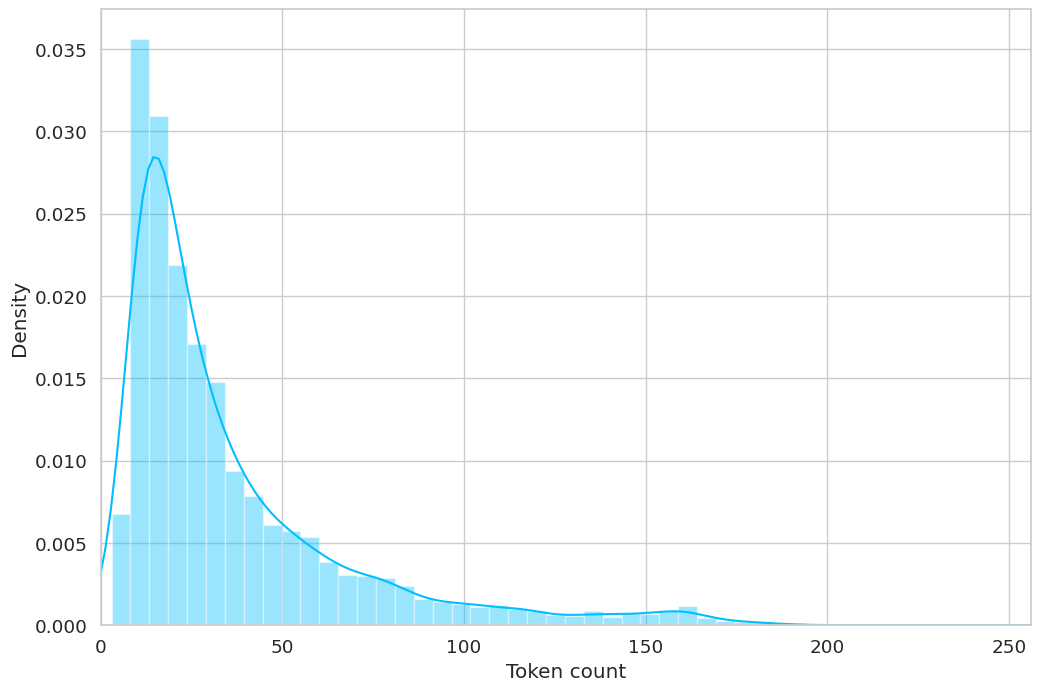

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of our values are less than 250, so we can probably set the MAX_SIZE value as a number around 250

In [ ]:
wolt_reviews.loc[wolt_reviews['content'].str.len() < 280].shape

(7478, 12)

In [ ]:
wolt_reviews = wolt_reviews.loc[wolt_reviews['content'].str.len() < 280]
wolt_reviews.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment
0,98f358bc-98d8-4b85-8507-e0c90564f834,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,запрашивает эмейл. не приходит код. тех поддер...,1,0,None,2025-03-17 15:49:13,None,None,None,0
1,dab3cf83-d070-4489-952e-d39121fd1920,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Не понятна сумма минимального заказа, не удало...",1,0,None,2025-03-17 14:26:55,None,None,None,0
3,ad39cccc-2d11-4c9a-996f-6c41508b5d91,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Регу по проще сделайте. Не смог войти удалил с...,1,0,None,2025-03-16 17:47:33,None,None,None,0
4,2c6ab6f0-620c-4f39-92c2-b92f9ad1b64c,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Отличная доставка,быстро,все отслеживается",5,0,25.10.1,2025-03-16 14:37:55,None,None,25.10.1,2
8,cc62ebd2-2c38-4437-b1ab-31ecfab54d29,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Рекомендую!!! Акции скидки и дешевлее чем Узум...,5,0,25.10.1,2025-03-16 13:18:32,None,None,25.10.1,2


Here, we clearly see that 280 is a good number as we have slightly more than required 200 reviews, so we set our MAX_LEN as 280

In [ ]:
MAX_LEN = 280

### Design a custom dataset class

In [ ]:
class ReviewDataset(Dataset): # inherit from pytorch Dataset
    # constructor
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews # our dataframe
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # len() method
    def __len__(self):
        return len(self.reviews)

    # get item  method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

### Split data into trainining, testing and evaluation datasets

In [ ]:
wolt_reviews_train, wolt_reviews_test = train_test_split(wolt_reviews, test_size=0.2, random_state=RANDOM_SEED)
wolt_reviews_val, wolt_reviews_test = train_test_split(wolt_reviews_test, test_size=0.5, random_state=RANDOM_SEED)

print(wolt_reviews_train.shape, wolt_reviews_val.shape, wolt_reviews_test.shape)

(5982, 12) (748, 12) (748, 12)


### Create a data loader for quick data return

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    '''
    Utility function to create an iteration based DataLoader
    '''
    ds = ReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(wolt_reviews_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(wolt_reviews_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(wolt_reviews_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Usage
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 280])
torch.Size([16, 280])
torch.Size([16])


## Reviews' sentiment analysis

Import the model from torch

In [ ]:
# Load the multilingual model
bert_model = BertModel.from_pretrained(MODEL_NAME) # bert-base-multilingual-cased

### Create a class for sentiment classification

In [ ]:
# Sentiment Classifier class
class ReviewSentimentClassifier(nn.Module):

    # constructor
    def __init__(self, n_classes):
        super(ReviewSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # forward propagaion method - basis of ML model training
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function (used for ML model evaluation and optimization) in PyTorch to work.

Create an instance of our Classifier class and move it to the GPU

In [ ]:
# Instantiate the model and move to classifier
class_names = ['negative', 'neutral', 'positive']

model = ReviewSentimentClassifier(len(class_names))
model = model.to(device)

### Training phase

In [ ]:
# number of training iterations
EPOCHS = 10

# user AdamW for model optimization
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# set loss function
loss_fn = nn.CrossEntropyLoss(Tensor(class_weights)).to(device)

In [ ]:
# single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0


    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)


        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )


        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

### Storing the best weights

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # epoch numbers
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(wolt_reviews_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(wolt_reviews_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.124770657263975 accuracy 0.551654964894684
Val   loss 1.24064302444458 accuracy 0.5975935828877005

Epoch 2/10
----------
Train loss 0.9056104463051985 accuracy 0.7739886325643597
Val   loss 1.0106489385696167 accuracy 0.8235294117647058

Epoch 3/10
----------
Train loss 0.812222646459698 accuracy 0.8523905048478769
Val   loss 0.9815409389582086 accuracy 0.8596256684491979

Epoch 4/10
----------
Train loss 0.753093736614773 accuracy 0.8784687395519892
Val   loss 1.0842685658246913 accuracy 0.8783422459893048

Epoch 5/10
----------
Train loss 0.6995821354243367 accuracy 0.8910063523905049
Val   loss 1.0527394672340535 accuracy 0.8890374331550802

Epoch 6/10
----------
Train loss 0.8249207755182197 accuracy 0.866098294884654
Val   loss 0.8596965749847129 accuracy 0.874331550802139

Epoch 7/10
----------
Train loss 0.7312291683380139 accuracy 0.9058843196255433
Val   loss 0.9808741995787367 accuracy 0.8877005347593583

Epoch 8/10
----------
Train loss 0.

### Plot training and validating accuracy

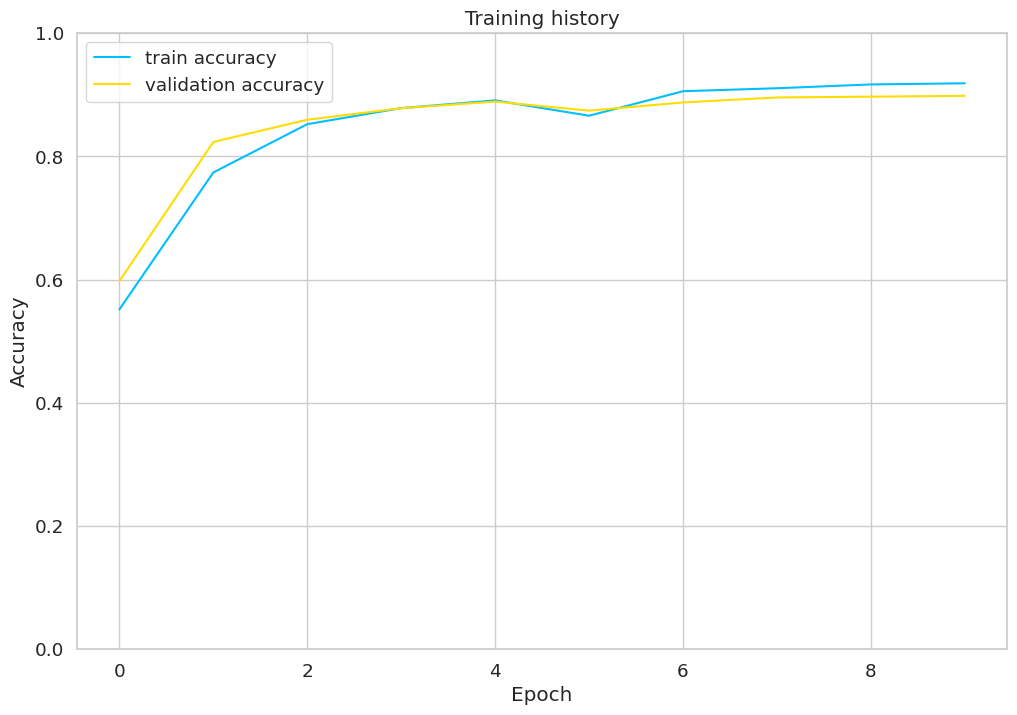

In [ ]:
# Plot training and validation accuracy

plt.plot([acc.cpu().numpy() for acc in history['train_acc']], label='train accuracy') # convert cuda tensors to numpy array for visualization
plt.plot([acc.cpu().numpy() for acc in history['val_acc']], label='validation accuracy')
# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Model evalution

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(wolt_reviews_test)
)

test_acc.item()

0.8596256684491979

### Define utility function for predictions

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       302
     neutral       0.00      0.00      0.00        17
    positive       0.91      0.88      0.89       429

    accuracy                           0.86       748
   macro avg       0.57      0.59      0.58       748
weighted avg       0.84      0.86      0.85       748



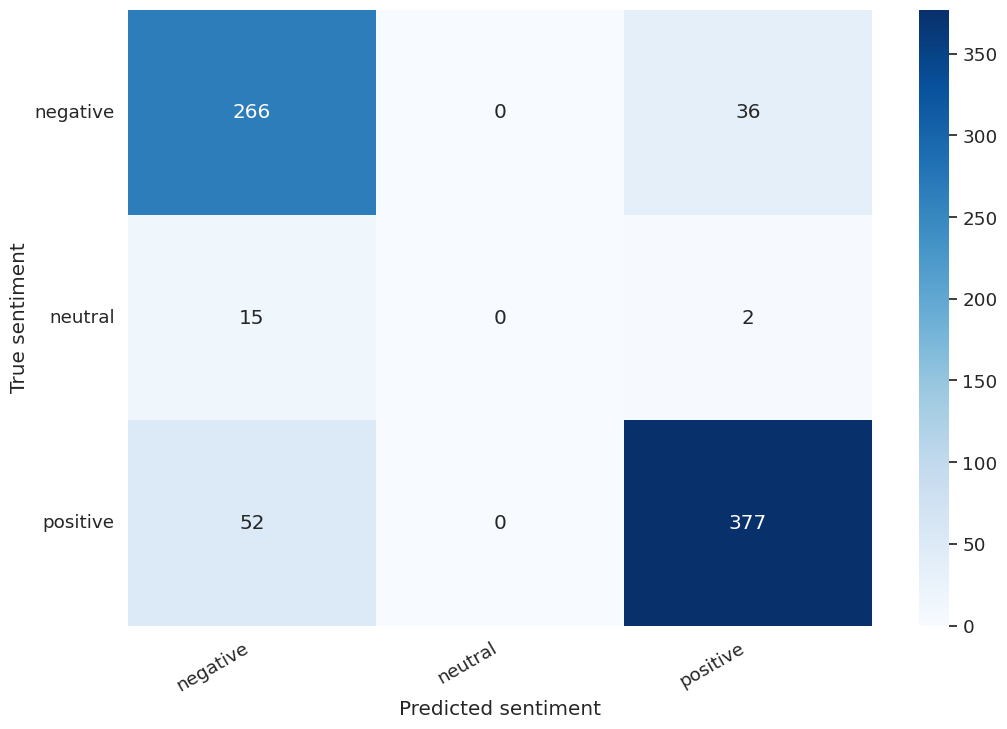

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Keyword extraction
For this purpose, we will gather all reviews of the Wolt App.

In [ ]:
wolt_reviews_all = reviews_all(
    wolt_id_android,
    lang="ru",
    country="kz"
)

wolt_reviews_all = pd.DataFrame(wolt_reviews)
wolt_reviews_all.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment
0,98f358bc-98d8-4b85-8507-e0c90564f834,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,запрашивает эмейл. не приходит код. тех поддер...,1,0,None,2025-03-17 15:49:13,None,None,None,0
1,dab3cf83-d070-4489-952e-d39121fd1920,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Не понятна сумма минимального заказа, не удало...",1,0,None,2025-03-17 14:26:55,None,None,None,0
3,ad39cccc-2d11-4c9a-996f-6c41508b5d91,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Регу по проще сделайте. Не смог войти удалил с...,1,0,None,2025-03-16 17:47:33,None,None,None,0
4,2c6ab6f0-620c-4f39-92c2-b92f9ad1b64c,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Отличная доставка,быстро,все отслеживается",5,0,25.10.1,2025-03-16 14:37:55,None,None,25.10.1,2
8,cc62ebd2-2c38-4437-b1ab-31ecfab54d29,Пользователь Google,https://play-lh.googleusercontent.com/EGemoI2N...,Рекомендую!!! Акции скидки и дешевлее чем Узум...,5,0,25.10.1,2025-03-16 13:18:32,None,None,25.10.1,2


Next, we will create a dataloader for this dataset, as well as get the predictions of our model for every single review of the Wolt app.

In [ ]:
keyword_data_loader = create_data_loader(wolt_reviews_all, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
all_reviews_texts, all_reviews_pred, _, _ = get_predictions(
    model,
    keyword_data_loader
)

In [ ]:
all_reviews_texts[:10]

['запрашивает эмейл. не приходит код. тех поддержки нет, там робот автоответчик ноль помощи. отвратительно!!!! даже не установив я устала и перехотела пользоваться этим приложением',
 'Не понятна сумма минимального заказа, не удалось добавить, т.к. мой заказ куда-то исчез. Жаль. 😥',
 'Регу по проще сделайте. Не смог войти удалил скачал узум тезкор',
 'Отличная доставка,быстро,все отслеживается',
 'Рекомендую!!! Акции скидки и дешевлее чем Узумтезкор и яндекс',
 'очень хорошие предложения',
 'пишет доставлено, еда не пришла , курьер вне досягаемости, тех поддержка молчит , беспредел не серьезное отношение',
 'очень,крутая доставка♥️',
 'Moja ulubiona aplikacja!!! Gorąco polecam!!!',
 'все шикарно, спасибо большое! доставка всегда быстрая! еда свежая! тех поддержка внимательная!']

In [ ]:
all_reviews_pred[:10]

tensor([0, 0, 0, 2, 2, 2, 0, 2, 2, 2])

In [ ]:
all_reviews = pd.DataFrame(zip(all_reviews_texts, all_reviews_pred), columns=['content', 'sentiment'])
all_reviews.sentiment = all_reviews.sentiment.astype(int)
all_reviews.head()

,content,sentiment
0,запрашивает эмейл. не приходит код. тех поддер...,0
1,"Не понятна сумма минимального заказа, не удало...",0
2,Регу по проще сделайте. Не смог войти удалил с...,0
3,"Отличная доставка,быстро,все отслеживается",2
4,Рекомендую!!! Акции скидки и дешевлее чем Узум...,2


In [ ]:
negative_reviews = all_reviews[all_reviews['sentiment'] == 0]
negative_reviews.head()

,content,sentiment
0,запрашивает эмейл. не приходит код. тех поддер...,0
1,"Не понятна сумма минимального заказа, не удало...",0
2,Регу по проще сделайте. Не смог войти удалил с...,0
6,"пишет доставлено, еда не пришла , курьер вне д...",0
10,"Если не хотите мотать нервы, не связывайтесь с...",0


In [ ]:
positive_reviews = all_reviews[all_reviews['sentiment'] == 2]
positive_reviews.head()

,content,sentiment
3,"Отличная доставка,быстро,все отслеживается",2
4,Рекомендую!!! Акции скидки и дешевлее чем Узум...,2
5,очень хорошие предложения,2
7,"очень,крутая доставка♥️",2
8,Moja ulubiona aplikacja!!! Gorąco polecam!!!,2


### Using a multilingual keyword extraction model - RAKE
Multilingual Rapid Automatic Keyword Extraction or **RAKE** for short is a powerful multilingual model with the following features:
- Automatic keyword extraction from text written in any language
- No need to have list of stopwords
- 26 available languages
- Simple functinoality

In [ ]:
!pip install multi-rake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 10.8 MB/s eta 0:00:00
  Created wheel for pycld2: filename=pycld2-0.41-cp311-cp311-linux_x86_64.whl size=9916407 sha256=1f9ad199450bd1df403ef9c79b912c16e3381a55bb73097e36f9eeab03c050c8
  Stored in directory: /root/.cache/pip/wheels/9a/71/a1/89cdc6ae2ecd7bb3bf67baee27a134f761b3e2922ea7fdfbcb
Successfully built pycld2


In [ ]:
from multi_rake import Rake

rake = Rake(
    min_chars=3,
    max_words=10,
    min_freq=2,
    language_code='ru',
    lang_detect_threshold=50,
    max_words_unknown_lang=1,
    generated_stopwords_percentile=80,
    generated_stopwords_max_len=3,
    generated_stopwords_min_freq=2,
)

In [ ]:
keywords = rake.apply('. '.join(negative_reviews['content']))

print(*keywords[:100], sep="\n")

('אני מוחקת את האפליקציה', 17.53333333333333)
('no money', 11.75)
('ждать заказ полтора часа', 10.96017121851168)
('пользоваться другими сервисами доставки', 10.672369878183831)
('самый худший сервис', 8.692907559198543)
('самое убогое приложение', 8.585878582202112)
('самый конченный сервис', 8.581796448087433)
('самая худшая доставка', 8.581045751633987)
('ввожу свой номер', 8.403246753246753)
('bolt food', 8.325980392156863)
('for example', 8.3125)
('убрать вашу рекламу', 8.175555555555555)
('самая долгая доставка', 8.126207041956569)
('самый ужасный сервис', 8.123463114754099)
('ужасная служба поддержки', 8.088878700817084)
('кадровая политика компании', 8.075)
('еда пришла холодной', 8.06779448621554)
('самая ужасная доставка', 8.042021361390084)
('самое худшее приложение', 8.002545248868778)
('создать новый аккаунт', 7.992771084337349)
('самое отстойное приложение', 7.852545248868779)
('служба поддержки вообще', 7.833458646616541)
('ненавижу вашу рекламу', 7.758888888888889)
('ед

In [ ]:
keywords = rake.apply(' '.join(positive_reviews['content']))

print(*keywords[:100], sep="\n")

('you are the best', 22.783915343915346)
('служба поддержки отвечает быстро', 11.979770117257655)
('любой страны сделать заказ', 11.681946006749158)
('удобное приложение отличное приложение', 11.528639490670596)
('самая лучшая доставка', 10.353113051418136)
('самый лучший сервис', 10.150091136933243)
('👍 отличное приложение', 10.036432330961517)
('fast delivery', 10.031531531531531)
('отличная служба поддержки', 9.995866535350823)
('самая быстрая доставка', 9.980202388593929)
('самое классное приложение', 9.841811272713597)
('good service', 9.795454545454545)
('служба доставки отличная', 9.690077553091253)
('самое лучшее приложение', 9.674117384680727)
('thank you', 9.52962962962963)
('love it', 9.5)
('хорошая служба доставки', 9.374125277351084)
('самое удобное приложение', 9.16716945231843)
('ocen udobno', 9.1)
('большой выбор блюд', 8.75)
('отличный сервис доставки', 8.683878941339604)
('большой выбор заведений', 8.605603448275861)
('целом хорошее приложение', 8.2805630174793)
('бол